In [1]:
import os
import sys

In [2]:
print(os.listdir('/kaggle/input/avazu-ctr-prediction'))

['sampleSubmission.gz', 'train.gz', 'test.gz']


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format

# Reading datasets

In [4]:
# Reading the input data

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values, nrows=100000)
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000371904215119872.00,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
1,10000720757801103360.00,0,2014-10-21,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,16920,320,50,1899,0,431,100077,117


In [38]:
# Reading the test data.
def f_read_test_data():
    test = pd.read_csv('../input/avazu-ctr-prediction/test.gz', parse_dates=['hour'], date_parser=parse_date, nrows=10000)
    return test.copy()
test = f_read_test_data()
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809263569,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855428,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51


In [6]:
# shape of the data read. 

print('Train dataset:',train.shape)
print('Test dataset:',test.shape)

Train dataset: (100000, 24)
Test dataset: (10000, 23)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                100000 non-null  float64       
 1   click             100000 non-null  int64         
 2   hour              100000 non-null  datetime64[ns]
 3   C1                100000 non-null  int64         
 4   banner_pos        100000 non-null  int64         
 5   site_id           100000 non-null  object        
 6   site_domain       100000 non-null  object        
 7   site_category     100000 non-null  object        
 8   app_id            100000 non-null  object        
 9   app_domain        100000 non-null  object        
 10  app_category      100000 non-null  object        
 11  device_id         100000 non-null  object        
 12  device_ip         100000 non-null  object        
 13  device_model      100000 non-null  object        
 14  devic

In [8]:
# Hour column contains event date with all the details, extracting the same to create different feature columns.

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10000371904215119872.00,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79,10,1,21,0
1,10000720757801103360.00,0,2014-10-21,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,16920,320,50,1899,0,431,100077,117,10,1,21,0


## Types of Features

In [9]:
#segrigating numerical and categorical variables.

numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


## Analyse Numerical Columns

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'click'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'C1'}>],
       [<AxesSubplot:title={'center':'banner_pos'}>,
        <AxesSubplot:title={'center':'device_type'}>,
        <AxesSubplot:title={'center':'device_conn_type'}>,
        <AxesSubplot:title={'center':'C14'}>],
       [<AxesSubplot:title={'center':'C15'}>,
        <AxesSubplot:title={'center':'C16'}>,
        <AxesSubplot:title={'center':'C17'}>,
        <AxesSubplot:title={'center':'C18'}>],
       [<AxesSubplot:title={'center':'C19'}>,
        <AxesSubplot:title={'center':'C20'}>,
        <AxesSubplot:title={'center':'C21'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour_time'}>, <AxesSubplot:>]],
      dtype=object)

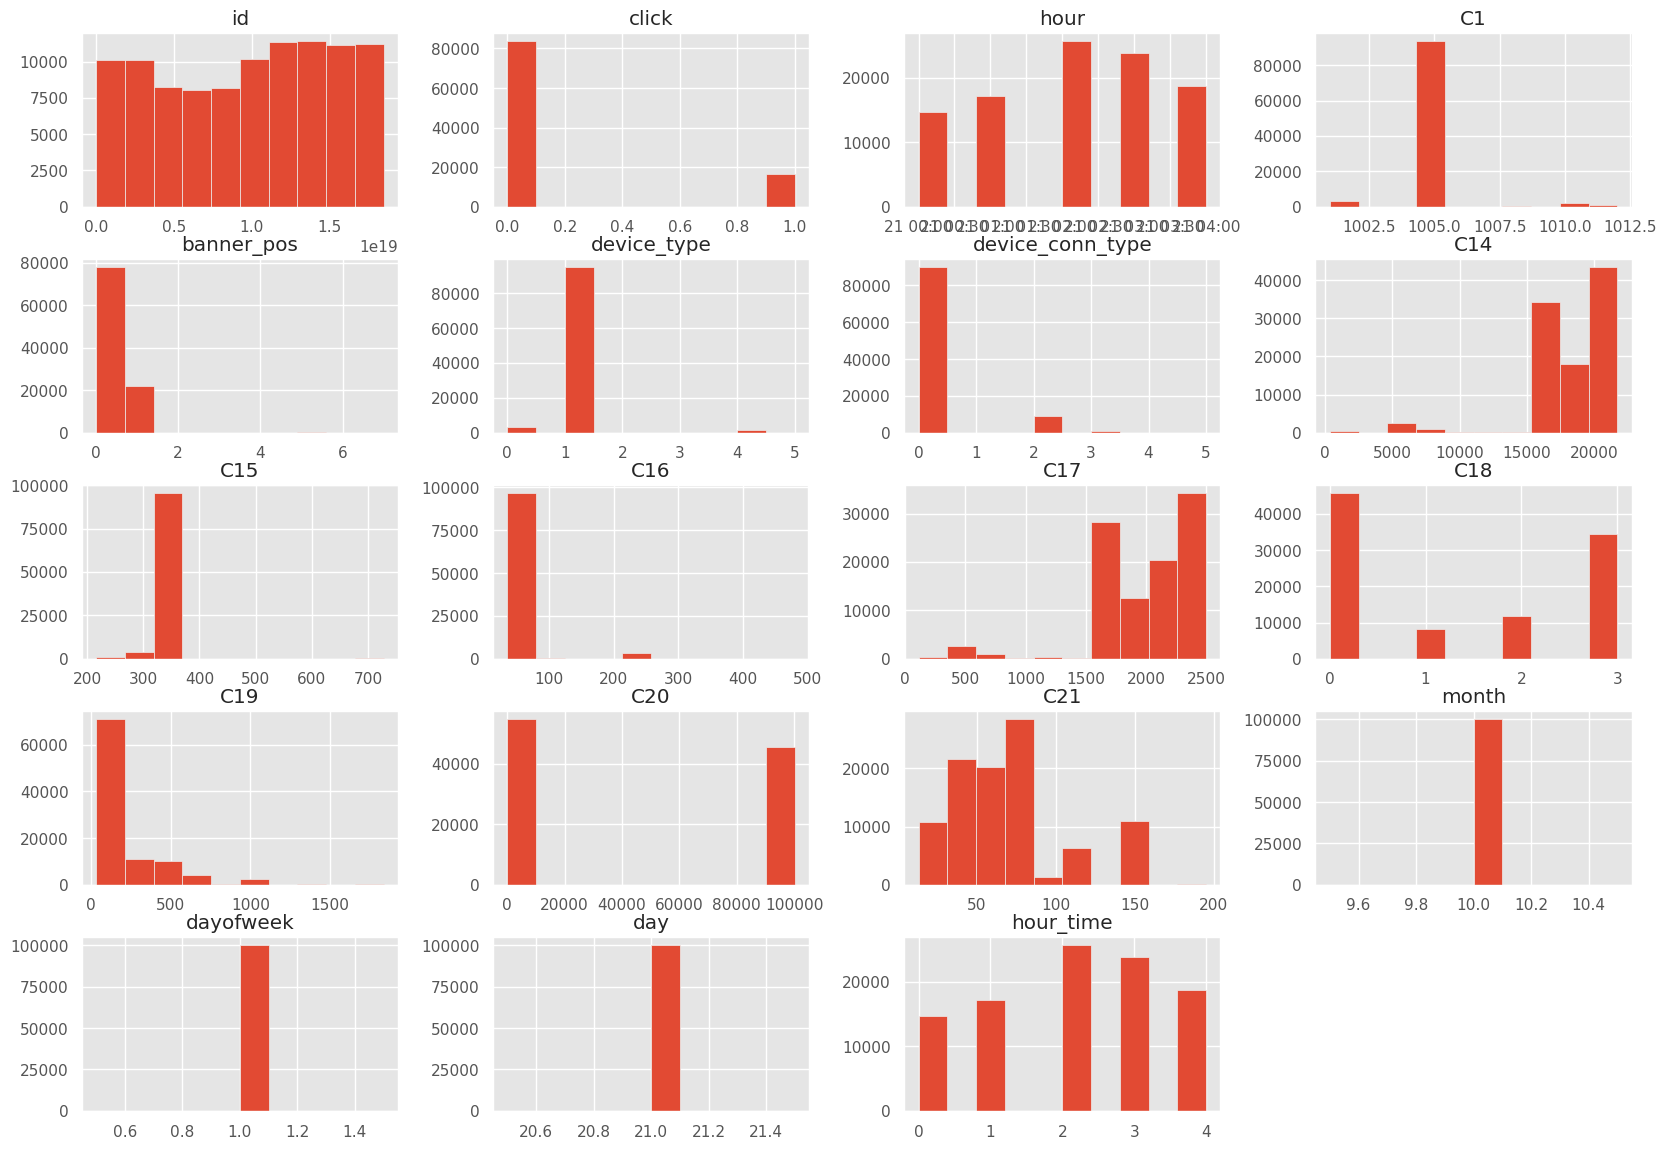

In [10]:
train[numerical].hist(figsize=(20,14))

### Looks like there are outliers in C15,C16, C19

In [11]:
# Cap the outliers of remove records where these column values are above 98 percentile
import numpy as np
Outlier_Col = ['C15', 'C16', 'C19']
for col in Outlier_Col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles
        print( col, np.percentile(train[col],98),train[col].quantile(0.98) )

C15 320.0 320.0


Text(0.5, 1.05, 'Pearson correlation of Features')

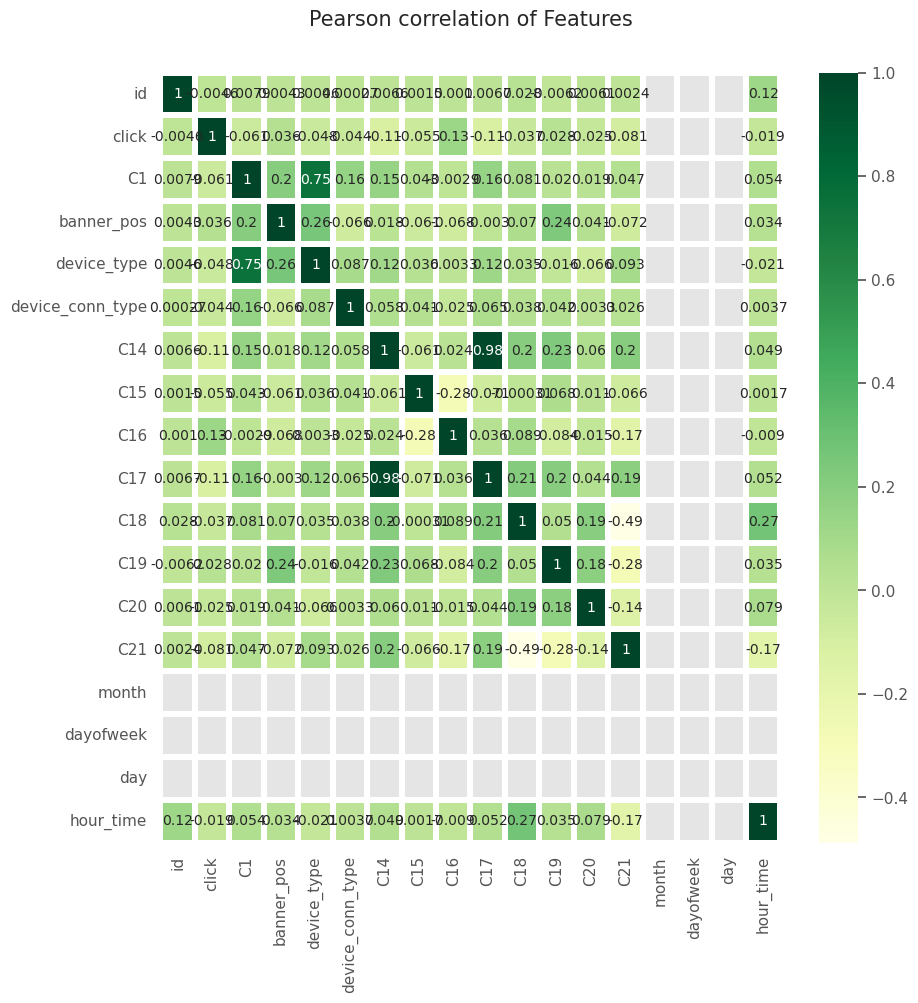

In [12]:
# Pearson correlation table to find the relationship with output with all input features. 

corr = train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

In [13]:
train['C20'].value_counts()

-1         54655
 100111     9922
 100084     8120
 100083     3411
 100077     2705
           ...  
 100109        1
 100097        1
 100244        1
 100016        1
 100114        1
Name: C20, Length: 152, dtype: int64

### Month has a constant value and C20 has large percentage of -1 values so drop them
### C14, C17 are highly correlated drop either of them

In [14]:
# as said above dropping columns. 

train.drop(['month', 'C20','C14'], axis=1, inplace=True)
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C15',
       'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour_time'],
      dtype='object')

In [15]:
# id column have a unique columns so nothing to learn from this column
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

train.drop(['id', 'hour'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C15', 'C16', 'C17',
       'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

## Analyse Categorical/ Sparse Features

0    83729
1    16271
Name: y, dtype: int64


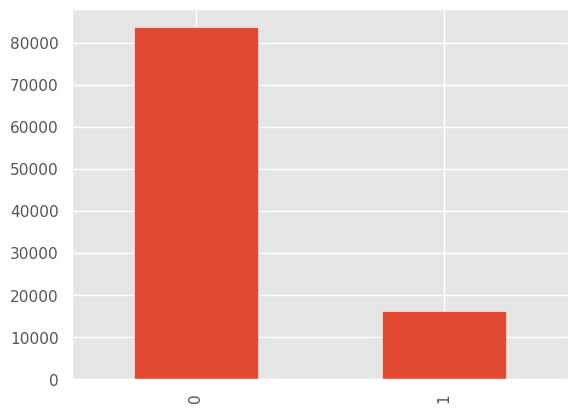

In [16]:
train.y.value_counts().plot(kind='bar')
print(train.y.value_counts())

<AxesSubplot:xlabel='banner_pos', ylabel='count'>

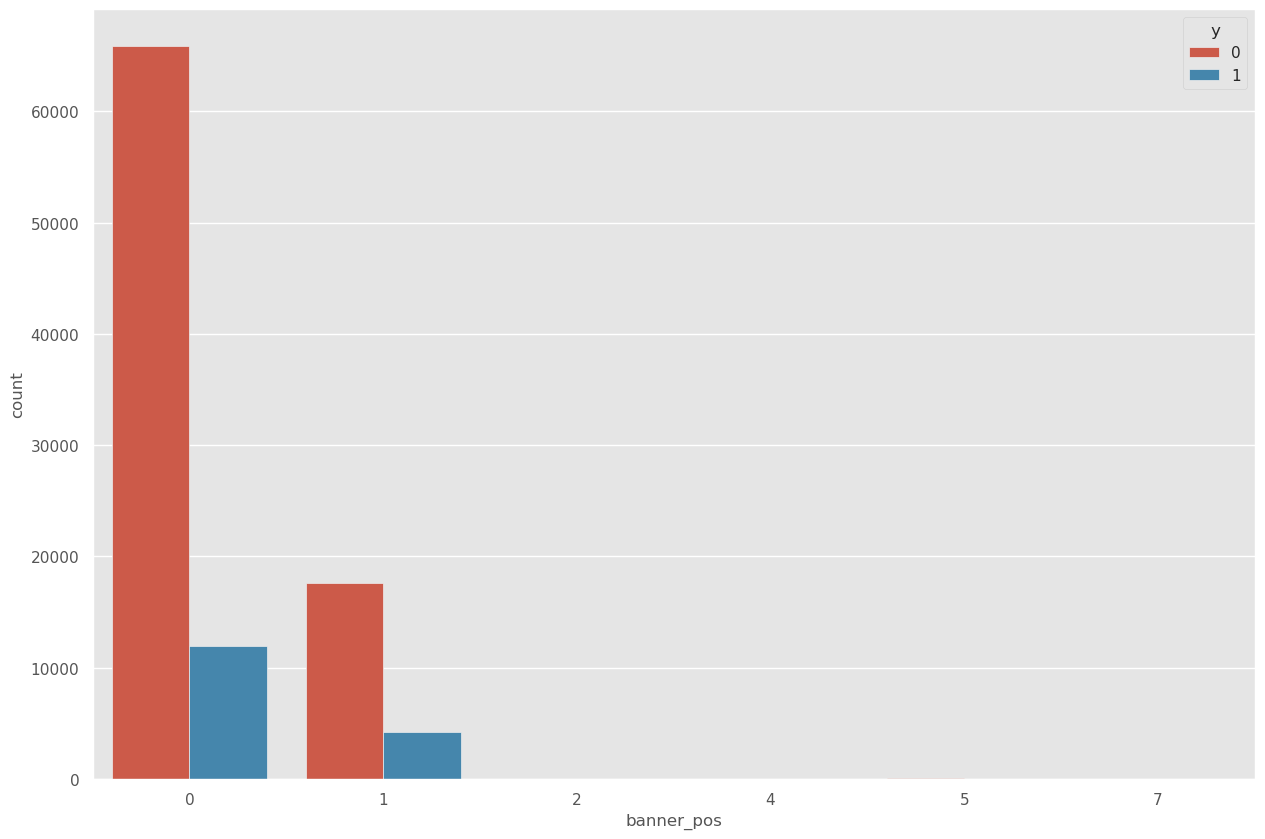

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(x='banner_pos',hue='y',data=train)

<AxesSubplot:xlabel='hour', ylabel='count'>

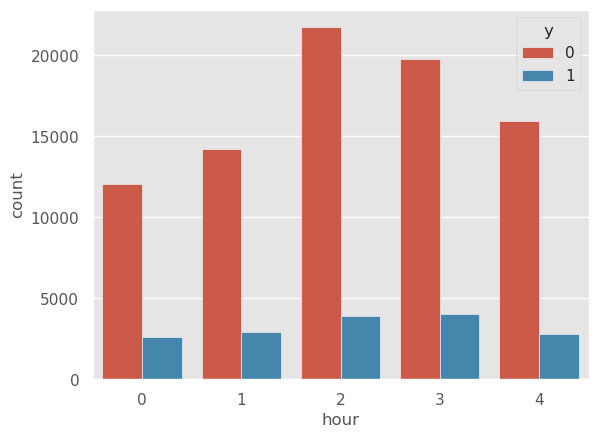

In [18]:
sns.countplot(x='hour',hue='y',data=train)

In [19]:
for col in categorical:
    print('Unique Values in ',col, ' = ',train[col].nunique(), ' :',len(train))

Unique Values in  site_id  =  1106  : 100000
Unique Values in  site_domain  =  953  : 100000
Unique Values in  site_category  =  18  : 100000
Unique Values in  app_id  =  1089  : 100000
Unique Values in  app_domain  =  80  : 100000
Unique Values in  app_category  =  21  : 100000
Unique Values in  device_id  =  12510  : 100000
Unique Values in  device_ip  =  62878  : 100000
Unique Values in  device_model  =  2930  : 100000


### Most of the categorical variables have lot of unique values in it, one hot encoding is not a scalable approach as it makes the feature vector large.
### label encoding and scaling is a better approach

### sparse feature
C1 
banner_pos   
site_id
site_domain 
site_category
app_id
app_domain
app_category
device_id
device_ip
device_model
device_type
device_conn_type

### Dense feature
C15 to c21

In [20]:
train.head()

,y,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,320,50,1722,0,35,79,1,21,0
1,0,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,320,50,1899,0,431,117,1,21,0
2,0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,c62f7206,69f9dd0e,1,0,320,50,2371,0,551,46,1,21,0
3,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,431b3174,f39b265e,1,0,320,50,1722,0,35,79,1,21,0
4,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,6769bdb2,d787e91b,1,0,320,50,2333,0,39,157,1,21,0


In [21]:
sparse_features = train.iloc[::,1:14].columns.values.tolist()
dense_features = train.iloc[::,14:14+6].columns.values.tolist()
sparse_features, dense_features

(['C1',
  'banner_pos',
  'site_id',
  'site_domain',
  'site_category',
  'app_id',
  'app_domain',
  'app_category',
  'device_id',
  'device_ip',
  'device_model',
  'device_type',
  'device_conn_type'],
 ['C15', 'C16', 'C17', 'C18', 'C19', 'C21'])

In [22]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
scaler = MinMaxScaler(feature_range=(0,1))
encoder = LabelEncoder()

## Encode Sparse Features and Scale Dense Features

In [23]:
data = train.copy()
data=data[sparse_features+dense_features+['y']]
for sparse in sparse_features:
    data[sparse] = encoder.fit_transform(data[sparse])
data[dense_features] = scaler.fit_transform(data[dense_features])
data.shape, train.shape

((100000, 20), (100000, 23))

## Pre-preprocess Test Data

In [42]:
test = f_read_test_data()
test['month'] = test['hour'].dt.month
test['dayofweek'] = test['hour'].dt.dayofweek
test['day'] = test['hour'].dt.day
test['hour_time'] = test['hour'].dt.hour

test.drop(['id', 'hour'], axis = 1, inplace = True) 
test.rename(columns={
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

test.columns

test_data = test.copy()
test_data=test_data[sparse_features+dense_features]
for sparse in sparse_features:
    test_data[sparse] = encoder.fit_transform(test_data[sparse])
test_data[dense_features] = scaler.fit_transform(test_data[dense_features])

test_data = torch.tensor(test_data.values).float()
test_data.shape, train.shape

(torch.Size([10000, 19]), (100000, 23))

In [24]:
sampled_data = data.copy() #sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']
del sampled_data

In [25]:
X.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21
0,2,0,123,907,1,1013,36,0,8274,44146,1574,1,0,1.00,0.03,0.68,0.00,0.00,0.36
1,2,0,907,718,16,1013,36,0,8274,1234,1574,1,0,1.00,0.03,0.75,0.00,0.22,0.57
2,2,1,957,482,16,1013,36,0,8274,48549,1213,1,0,1.00,0.03,0.95,0.00,0.29,0.18
3,2,0,123,907,1,1013,36,0,8274,16280,2775,1,0,1.00,0.03,0.68,0.00,0.00,0.36
4,2,0,381,752,3,1013,36,0,8274,25187,2472,1,0,1.00,0.03,0.93,0.00,0.00,0.79


In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [27]:
X = torch.tensor(X.values)
y = torch.tensor(y.values)
X.shape, y.shape

(torch.Size([100000, 19]), torch.Size([100000]))

In [28]:
X[0:32].shape, y[0:32].float().view(-1,1).shape


(torch.Size([32, 19]), torch.Size([32, 1]))

## Model Architecture

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class TransformerModel(nn.Module):
    def __init__(self, visual_embedding_dim, tabular_feature_dim, num_heads, hidden_dim, num_layers):
        super(TransformerModel, self).__init__()

        # Visual embedding encoder
        self.visual_encoder = nn.Linear(visual_embedding_dim, hidden_dim)

        # Tabular data encoder
        self.tabular_encoder = nn.Sequential(
            nn.Linear(tabular_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Transformer encoder
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim*2, num_heads, dim_feedforward=4*hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)

        # Output layer
        self.output_layer = nn.Linear(hidden_dim*2, 1)

    def forward(self, visual_input, tabular_input):
        # Visual embedding encoding
        visual_embedding = self.visual_encoder(visual_input)

        # Tabular data encoding
        #print(tabular_input)
        tabular_embedding = self.tabular_encoder(tabular_input)

        # Concatenate visual and tabular embeddings
        #print('before concat =>',visual_embedding.shape, visual_embedding.dtype,tabular_embedding.shape)
        combined_embedding = torch.cat((visual_embedding, tabular_embedding), dim=1)

        # Transformer encoding
        #print('After Concatenation ',combined_embedding.shape)
        transformer_output = self.transformer_encoder(combined_embedding)

        # Output layer
        output = self.output_layer(transformer_output)

        # Sigmoid activation for click-through rate
        output = torch.sigmoid(output)

        return output

# Example usage:
model = TransformerModel(visual_embedding_dim=2048, tabular_feature_dim=19, num_heads=8, hidden_dim=512, num_layers=4)
#print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

visual_input = torch.randn(32, 2048).float()
tabular_input = torch.randn(32, 32)
label = torch.randint(0, 2, (32, 1)).float()

tabular_input = X[0:32].float()
label = y[0:32].float().view(-1,1)

print('Input shapes Visual and tabular')
print('================================')
print(visual_input.shape, tabular_input.shape, 'Visual Dtype =>',visual_input.dtype)
output = model(visual_input, tabular_input)
print('Output ',output.shape)
print('Label ',label.shape)
loss = criterion(output, label)

loss.backward()
optimizer.step()
print(loss)

Input shapes Visual and tabular
torch.Size([32, 2048]) torch.Size([32, 19]) Visual Dtype => torch.float32
Output  torch.Size([32, 1])
Label  torch.Size([32, 1])
tensor(0.6193, grad_fn=<BinaryCrossEntropyBackward0>)


In [31]:
# hyperparameters
batch_size = 32 # how many independent feature vectors will we process in parallel?
max_iters = 100
eval_interval = 2
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.0

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data), (batch_size,)) # generate 32 random indexes of feature set
    #print(ix)
    x = torch.stack( [X[i].float() for i in ix] )
    target = torch.stack([y[i].float() for i in ix])
    target = target.view(-1,1)
    #print('Function : ',x.shape, target.shape)
    x, target = x.to(device), target.to(device)
    return x, target

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            #print('Eval Function ',X.shape, Y.shape)
            visual_input = torch.randn(32, 2048).float()
            visual_input = visual_input.to(device)
            output = model(visual_input, X)
            loss = criterion(output, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    #print(xb.shape,yb.shape)
    # evaluate the loss
    visual_input = torch.randn(32, 2048).float()
    visual_input = visual_input.to(device)
    output = model(visual_input, xb)
    loss = criterion(output, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


43.322369 M parameters
step 0: train loss 2.3645, val loss 2.4231
step 2: train loss 0.8716, val loss 0.8487
step 4: train loss 0.5733, val loss 0.5729
step 6: train loss 0.5524, val loss 0.5519
step 8: train loss 0.8037, val loss 0.8258
step 10: train loss 0.5860, val loss 0.5731
step 12: train loss 0.4654, val loss 0.4580
step 14: train loss 0.5631, val loss 0.5692
step 16: train loss 0.4477, val loss 0.4648
step 18: train loss 0.4860, val loss 0.4821
step 20: train loss 0.5176, val loss 0.5504
step 22: train loss 0.5328, val loss 0.5474
step 24: train loss 0.4371, val loss 0.4720
step 26: train loss 0.4521, val loss 0.4416
step 28: train loss 0.5076, val loss 0.5194
step 30: train loss 0.4919, val loss 0.4854
step 32: train loss 0.4489, val loss 0.4509
step 34: train loss 0.4678, val loss 0.4465
step 36: train loss 0.4881, val loss 0.4873
step 38: train loss 0.4628, val loss 0.4692
step 40: train loss 0.4827, val loss 0.4664
step 42: train loss 0.4619, val loss 0.4425
step 44: train

## Prediction on Test Data

In [48]:
test_tab_x = test_data[32:32+32].to(device)
pred_ans = model(visual_input, test_tab_x)
pred_ans

tensor([[0.1198],
        [0.1218],
        [0.1186],
        [0.1151],
        [0.1149],
        [0.1133],
        [0.1268],
        [0.1244],
        [0.1214],
        [0.1196],
        [0.1224],
        [0.1162],
        [0.1208],
        [0.1158],
        [0.1067],
        [0.1152],
        [0.1166],
        [0.1118],
        [0.1205],
        [0.1094],
        [0.1192],
        [0.1179],
        [0.1235],
        [0.1224],
        [0.1285],
        [0.1241],
        [0.1202],
        [0.1234],
        [0.1225],
        [0.1181],
        [0.1239],
        [0.1257]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
import pandas as pd

# # Load Criteo dataset
# data = pd.read_csv('path/to/criteo/dataset.txt', sep='\t', header=None)

# # Take a random subset of the dataset for faster processing
# data = data.sample(frac=0.1)

# Extract categorical and numerical features
categorical_cols = categorical #data.columns[:13].tolist()
numerical_cols = numerical #data.columns[13:].tolist()

# Convert categorical features to one-hot encoding
data[categorical_cols] = data[categorical_cols].astype('category')
data = pd.get_dummies(data, columns=categorical_cols)

# Normalize numerical features
numerical_data = data[numerical_cols]
normalized_data = (numerical_data - numerical_data.mean()) / numerical_data.std()
data[numerical_cols] = normalized_data

# Calculate tabular feature dimension
tabular_feature_dim = len(data.columns)
print(f"Tabular feature dimension: {tabular_feature_dim}")


## Image Embeddings

In [44]:
# !pip install git+https://github.com/openai/CLIP.git
os.listdir('/kaggle/input/256x256-images/')

['train.zip',
 'masks.zip',
 '__results__.html',
 '__notebook__.ipynb',
 '__results___files',
 '__output__.json',
 'custom.css']

In [ ]:
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

import sys
sys.path.append('./CLIP')

import clip
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device) # pretrained on ImageNet
for img in img_path:
        #img = Image.open(fetch(path)).convert('RGB')
        print('Reading img prompt..', img)
        img = Image.open(path+img).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        img_embed = clip_model.encode_image(normalize(batch)).float()
print(img_embed.shape)